In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
from scipy import stats

In [2]:
def create_imbalanced_dataset(n_samples=1000, n_features=20, n_classes=2, imbalance_ratio=0.1):
	X, y = make_classification(
		n_samples=n_samples,
		n_features=n_features,
		n_redundant=0,
		n_informative=n_features,
		n_classes=n_classes,
		random_state=42
	)

	minority_indices = np.where(y == 1)[0]
	n_minority_keep = int(len(minority_indices) * imbalance_ratio)
	keep_minority = np.random.choice(minority_indices, n_minority_keep, replace=False)

	majority_indices = np.where(y == 0)[0]
	keep_indices = np.concatenate([majority_indices, keep_minority])

	X_imbalanced = X[keep_indices]
	y_imbalanced = y[keep_indices]

	return X_imbalanced, y_imbalanced

class Generator(nn.Module):
	def __init__(self, noise_dim, data_dim, hidden_dim=128):
		super(Generator, self).__init__()
		self.network = nn.Sequential(
			nn.Linear(noise_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, data_dim),
			nn.Tanh()
		)

	def forward(self, noise):
		return self.network(noise)
	
class Discriminator(nn.Module):
	def __init__(self, noise_dim, data_dim, hidden_dim=128):
		super(Discriminator, self).__init__()
		self.network = nn.Sequential(
			nn.Linear(data_dim, hidden_dim),
			nn.LeakyReLU(0.2),
			nn.Dropout(0.3),
			nn.Linear(hidden_dim, hidden_dim),
			nn.LeakyReLU(0.2),
			nn.Dropout(0.3),
			nn.Linear(hidden_dim, 1),
			nn.Sigmoid()	# Output probability
		)
	
	def forward(self, data):
		return self.network(data)
	
class GANOversampler:
	def __init__(self, data_dim, noise_dim=32, batch_size=64, lr=0.0002, device='cpu'):
		self.device = device
		self.noise_dim = noise_dim
		self.data_dim = data_dim

		self.generator = Generator(noise_dim, data_dim).to(device)
		self.discriminator = Discriminator(noise_dim, data_dim).to(device)

		self.gen_optimizer = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
		self.disc_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

		self.criterion = nn.BCELoss()

	def train(self, minority_data, epochs=1000, batch_size=32, print_interval=100):
		minority_tensor = torch.FloatTensor(minority_data).to(self.device)
		dataloader = DataLoader(TensorDataset(minority_tensor), batch_size=batch_size, shuffle=True)

		gen_losses = []
		disc_losses = []

		for epoch in range(epochs):
			epoch_gen_loss = 0
			epoch_disc_loss = 0

			for batch_idx, (real_data, ) in enumerate(dataloader):
				real_data = real_data.to(self.device)
				batch_size = real_data.size(0)

				# Train Discriminator
				self.disc_optimizer.zero_grad()

				real_labels = torch.ones(batch_size, 1).to(self.device)
				real_output = self.discriminator(real_data)
				real_loss = self.criterion(real_output, real_labels)

				noise = torch.randn(batch_size, self.noise_dim).to(self.device)
				fake_data = self.generator(noise)
				fake_labels = torch.zeros(batch_size, 1).to(self.device)
				fake_output = self.discriminator(fake_data.detach())
				fake_loss = self.criterion(fake_output, fake_labels)

				# Total discriminator loss
				disc_loss = real_loss + fake_loss
				disc_loss.backward()
				self.disc_optimizer.step()

				# Train Generator
				self.gen_optimizer.zero_grad()

				# Generate fake data and try to fool discriminator
				noise = torch.randn(batch_size, self.noise_dim).to(self.device)
				fake_data = self.generator(noise)
				fake_output = self.discriminator(fake_data)
				gen_loss = self.criterion(fake_output, real_labels)  # Want discriminator to think it's real

				gen_loss.backward()
				self.gen_optimizer.step()

				epoch_gen_loss += gen_loss.item()
				epoch_disc_loss += disc_loss.item()

			gen_losses.append(epoch_gen_loss / len(dataloader))
			disc_losses.append(epoch_disc_loss / len(dataloader))

			if epoch % print_interval == 0:
				print(f'Epoch [{epoch}/{epochs}], Gen Loss: {gen_losses[-1]:.4f}, Disc Loss: {disc_losses[-1]:.4f}')
			
		return gen_losses, disc_losses
	
	def generate_samples(self, n_samples):
		self.generator.eval()
		with torch.no_grad():
			noise = torch.randn(n_samples, self.noise_dim).to(self.device)
			synthetic_data = self.generator(noise)

		return synthetic_data.cpu().numpy()
	
def oversample_with_gan(X, y, target_class=1, oversample_ratio=1.0, epochs=1000):
	"""
	Oversample minority class using GAN.

	Args:
		X (np.ndarray): Feature matrix.
		y (np.ndarray): Labels.
		target_class (int): The minority class to oversample.
		oversample_ratio (float): Ratio of oversampling (e.g., 1.0 means double the minority class).
		epochs (int): Number of training epochs for GAN.
	"""
	minority_mask = y == target_class
	majority_mask = y != target_class

	minority_data = X[minority_mask]
	majority_data = X[majority_mask]

	# print(f'Original class distribution: {Counter(y)}')
	print(f'Original class distribution:')
	print(f'Majority class: {len(majority_data)} samples')
	print(f'Minority class: {len(minority_data)} samples')

	scaler = StandardScaler()
	minority_data_scaled = scaler.fit_transform(minority_data)

	device = 'mps' if torch.backends.mps.is_available() else 'cpu'
	print(f'Using device: {device}')

	gan = GANOversampler(
		data_dim=minority_data.shape[1],
		noise_dim=100,
		lr=0.0002,
		device=device
	)

	print('Training GAN...')
	gen_losses, disc_losses = gan.train(
		minority_data_scaled,
		epochs=epochs,
		batch_size=32,
		print_interval=100
	)

	n_majority = len(majority_data)
	n_minority = len(minority_data)
	n_generate = int((n_majority * oversample_ratio) - n_minority)

	if n_generate > 0:
		print(f'Generating {n_generate} synthetic samples...')
		synthetic_data_scaled = gan.generate_samples(n_generate)

		# Transform back to original scale
		synthetic_data = scaler.inverse_transform(synthetic_data_scaled)
		synthetic_labels = np.full(n_generate, target_class)

		# Evaluate synthetic data quality
		evaluation_results = evaluate_synthetic_quality(minority_data, synthetic_data)
		print(f'Synthetic Data Quality - Mean KL Divergence:')
		print(f'Mean KL Divergence: {evaluation_results["mean_kl_divergence"]:.6f}')
		print(f'Mean JS Divergence: {evaluation_results["mean_js_divergence"]:.6f}')
		print(f'KS Mean Statistic: {evaluation_results["ks_mean_stat"]:.6f}, KS Mean p-value: {evaluation_results["ks_mean_pvalue"]:.6f}')

		# Combine original and synthetic data
		X_balanced = np.vstack([X, synthetic_data])
		y_balanced = np.concatenate([y, synthetic_labels])

		print(f'\nFinal class distribution after oversampling:')
		print(f'Total samples: {len(y_balanced)}')
		print(f'Majority class: {len(X_balanced[y_balanced != target_class])} samples')
		print(f'Minority class: {len(X_balanced[y_balanced == target_class])} samples')
		print(Counter(y_balanced))

		return X_balanced, y_balanced, gen_losses, disc_losses, synthetic_data, synthetic_labels
	else:
		print('No oversampling needed.')
		return X, y, gen_losses, disc_losses, None, None
	
def calculate_kl_divergence(real_data, synthetic_data, bins=50):
	"""
	Calculate KL Divergence between real and synthetic data distributions.

	Args:
		real_data (np.ndarray): Real data samples.
		synthetic_data (np.ndarray): Synthetic data samples.
		bins (int): Number of bins for histogram estimation.
	Returns:
		float: Mean KL Divergence across all features.
	"""
	n_features = real_data.shape[1]
	kl_divs = []

	for i in range(n_features):
		real_feature = real_data[:, i]
		synthetic_feature = synthetic_data[:, i]

		# Create common range for both distributions
		min_val = min(real_feature.min(), synthetic_feature.min())
		max_val = max(real_feature.max(), synthetic_feature.max())
		bin_edges = np.linspace(min_val, max_val, bins + 1)

		# calculate histograms (probability distributions)
		real_hist, _ = np.histogram(real_feature, bins=bin_edges, density=True)
		synthetic_hist, _ = np.histogram(synthetic_feature, bins=bin_edges, density=True)

		real_hist = real_hist / real_hist.sum()  # Normalize to get probabilities
		synthetic_hist = synthetic_hist / synthetic_hist.sum()

		# Add small epsilon to avoid log(0)
		epsilon = 1e-10
		real_hist += epsilon
		synthetic_hist += epsilon

		# Calculate KL divergence: KP(P||Q) where P is real, Q is synthetic
		kl = entropy(real_hist, synthetic_hist)
		kl_divs.append(kl)

	return np.mean(kl_divs), kl_divs

def calculate_js_divergence(real_data, synthetic_data, bins=50):
	"""
	Calculate Jensen-Shannon Divergence between real and synthetic data distributions.

	Args:
		real_data (np.ndarray): Real data samples.
		synthetic_data (np.ndarray): Synthetic data samples.
		bins (int): Number of bins for histogram estimation.
	Returns:
		float: Mean JS Divergence across all features.
	"""
	n_features = real_data.shape[1]
	js_divs = []

	for i in range(n_features):
		real_feature = real_data[:, i]
		synthetic_feature = synthetic_data[:, i]

		# Create common range for both distributions
		min_val = min(real_feature.min(), synthetic_feature.min())
		max_val = max(real_feature.max(), synthetic_feature.max())
		bin_edges = np.linspace(min_val, max_val, bins + 1)

		# calculate histograms (probability distributions)
		real_hist, _ = np.histogram(real_feature, bins=bin_edges, density=True)
		synthetic_hist, _ = np.histogram(synthetic_feature, bins=bin_edges, density=True)

		real_hist = real_hist / real_hist.sum()
		synthetic_hist = synthetic_hist / synthetic_hist.sum()

		epsilon = 1e-10
		real_hist += epsilon
		synthetic_hist += epsilon

		js_div = jensenshannon(real_hist, synthetic_hist) ** 2  # Square to get divergence
		js_divs.append(js_div)

	return np.mean(js_divs), js_divs

def evaluate_synthetic_quality(real_data, synthetic_data):
	"""
	Comprehensive evaluation of synthetic data quality.

	Args:
		real_data (np.ndarray): Real data samples.
		synthetic_data (np.ndarray): Synthetic data samples.

	Returns:
		dict: Dictionary with KL and JS divergence metrics.
	"""
	mean_kl, kl_per_feature = calculate_kl_divergence(real_data, synthetic_data)
	mean_js, js_per_feature = calculate_js_divergence(real_data, synthetic_data)

	n_features = real_data.shape[1]
	ks_stats = []
	ks_pvalues = []

	for i in range(n_features):
		# Kolmogorov-Smirnov test
		ks_stat, ks_pval = stats.ks_2samp(real_data[:, i], synthetic_data[:, i])
		ks_stats.append(ks_stat)
		ks_pvalues.append(ks_pval)

	results = {
		'mean_kl_divergence': mean_kl,
		'mean_js_divergence': mean_js,
		'kl_per_feature': kl_per_feature,
		'js_per_feature': js_per_feature,
		'ks_stats_per_feature': ks_stats,
		'ks_pvalues_per_feature': ks_pvalues,
		'ks_mean_stat': np.mean(ks_stats),
		'ks_mean_pvalue': np.mean(ks_pvalues)
	}

	return results

def plot_feature_distributions(real_data, synthetic_data, n_features_plot=4):
	"""
	Plot feature distributions for real and synthetic data.

	Args:
		real_data (np.ndarray): Real data samples.
		synthetic_data (np.ndarray): Synthetic data samples.
		n_features_plot (int): Number of features to plot.
	"""
	n_features = real_data.shape[1]
	fig, axes = plt.subplots(2, 2, figsize=(12, 10))
	axes = axes.ravel()

	for i in range(min(n_features_plot, n_features)):
		axes[i].hist(real_data[:, i], bins=30, alpha=0.7, label='Real', density=True)
		axes[i].hist(synthetic_data[:, i], bins=30, alpha=0.7, label='Synthetic', density=True)
		axes[i].set_title(f'Feature {i} Distribution')
		axes[i].set_xlabel('Value')
		axes[i].set_ylabel('Density')
		axes[i].legend()

	plt.tight_layout()
	plt.show()

Original class distribution: Counter({np.int64(0): 5003, np.int64(1): 499})
Original class distribution:
Majority class: 5003 samples
Minority class: 499 samples
Using device: mps
Training GAN...
Training GAN...
Epoch [0/1000], Gen Loss: 0.6935, Disc Loss: 1.3806
Epoch [0/1000], Gen Loss: 0.6935, Disc Loss: 1.3806
Epoch [100/1000], Gen Loss: 4.9973, Disc Loss: 0.0351
Epoch [100/1000], Gen Loss: 4.9973, Disc Loss: 0.0351
Epoch [200/1000], Gen Loss: 7.9210, Disc Loss: 0.0205
Epoch [200/1000], Gen Loss: 7.9210, Disc Loss: 0.0205
Epoch [300/1000], Gen Loss: 9.4265, Disc Loss: 0.0012
Epoch [300/1000], Gen Loss: 9.4265, Disc Loss: 0.0012
Epoch [400/1000], Gen Loss: 11.7013, Disc Loss: 0.0001
Epoch [400/1000], Gen Loss: 11.7013, Disc Loss: 0.0001
Epoch [500/1000], Gen Loss: 11.9299, Disc Loss: 0.0001
Epoch [500/1000], Gen Loss: 11.9299, Disc Loss: 0.0001
Epoch [600/1000], Gen Loss: 12.3353, Disc Loss: 0.0001
Epoch [600/1000], Gen Loss: 12.3353, Disc Loss: 0.0001
Epoch [700/1000], Gen Loss: 14

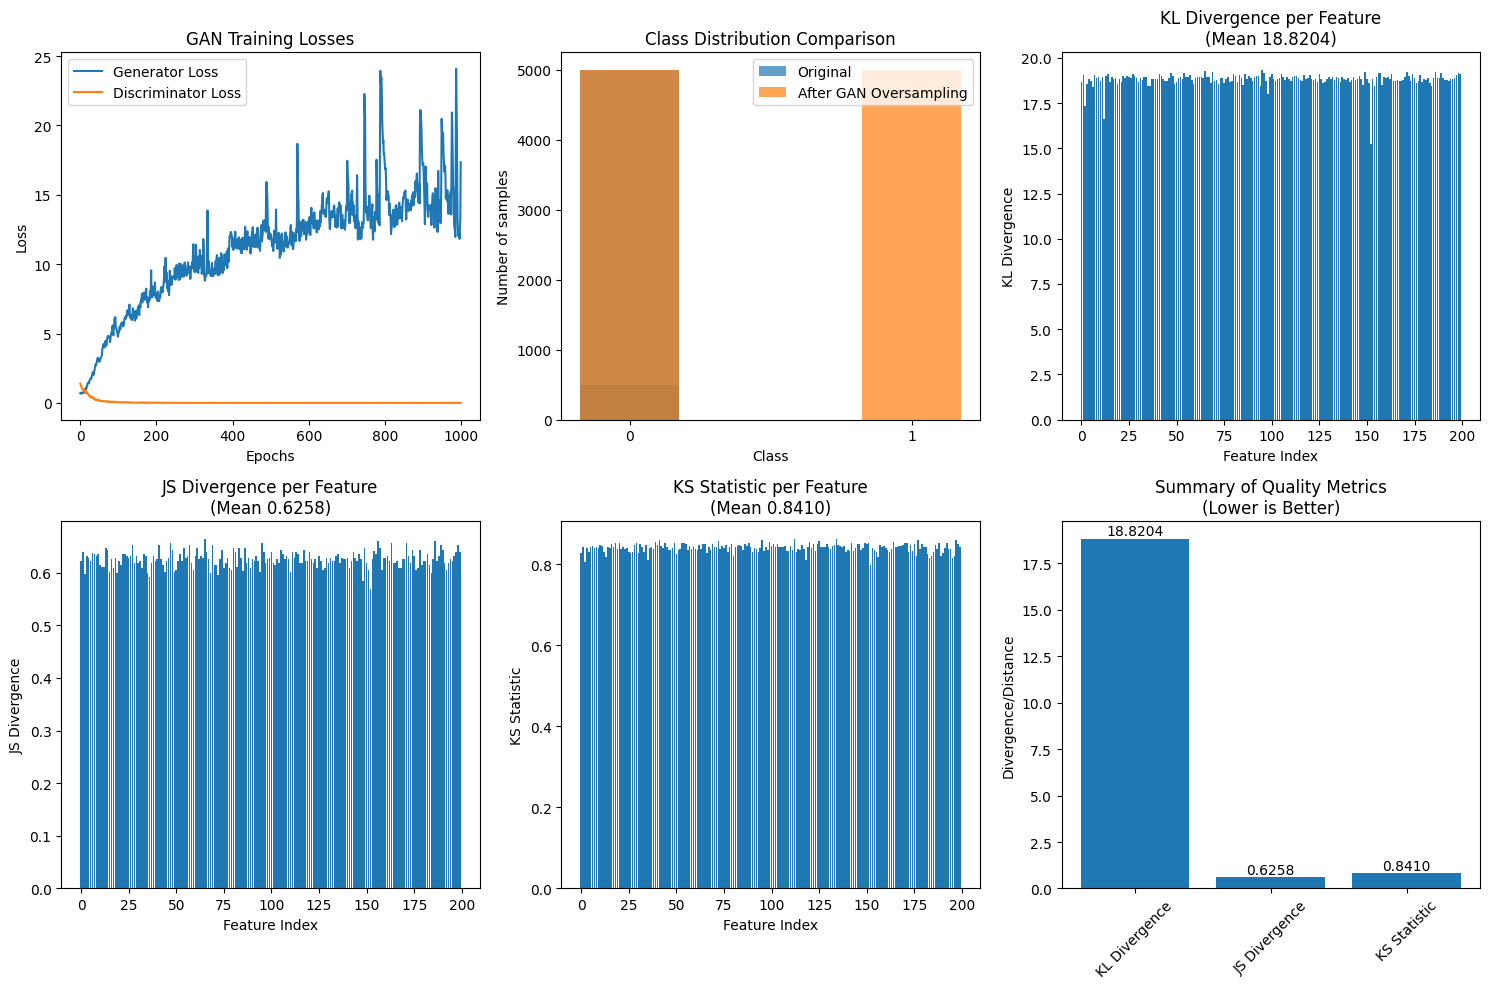


Original dataset shape: (5502, 200), Balanced dataset shape: (10006, 200)


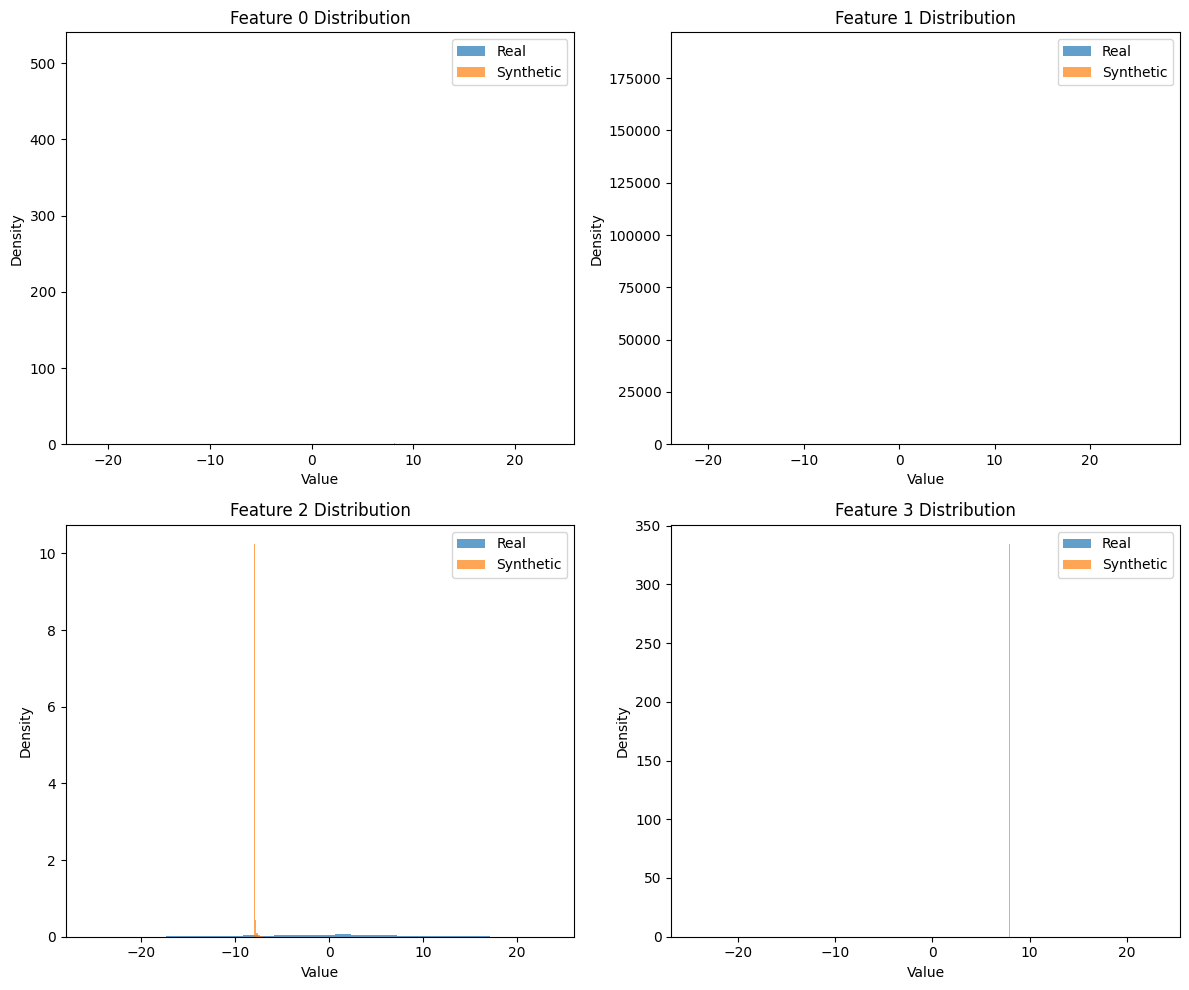

In [3]:
if __name__ == '__main__':
	X, y = create_imbalanced_dataset(n_samples=10000, n_features=200, imbalance_ratio=0.1)

	print(f'Original class distribution:', Counter(y))

	# Oversample using GAN
	X_balanced, y_balanced, gen_losses, disc_losses, synthetic_data, synthetic_labels = oversample_with_gan(
		X, y,
		target_class=1,
		oversample_ratio=1.0,
		epochs=1000,
	)

	# Plot training losses
	plt.figure(figsize=(15, 10))

	plt.subplot(2, 3, 1)
	plt.plot(gen_losses, label='Generator Loss')
	plt.plot(disc_losses, label='Discriminator Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('GAN Training Losses')
	plt.legend()

	plt.subplot(2, 3, 2)
	# Compare original vs balanced class distribution
	classes, counts_original = np.unique(y, return_counts=True)
	classes_balanced, counts_balanced = np.unique(y_balanced, return_counts=True)

	x = np.arange(len(classes))
	width = 0.35

	plt.bar((x - width/2).astype(int), counts_original, width, label='Original', alpha=0.7)
	plt.bar((x + width/2).astype(int), counts_balanced, width, label='After GAN Oversampling', alpha=0.7)

	plt.xlabel('Class')
	plt.ylabel('Number of samples')
	plt.title('Class Distribution Comparison')
	plt.xticks(x, classes.astype(str).tolist())
	plt.legend()

	if synthetic_data is not None:
		# Get evaluation results
		minority_data = X[y == 1]
		eval_results = evaluate_synthetic_quality(minority_data, synthetic_data)
		
		# KL Divergence per feature
		plt.subplot(2, 3, 3)
		plt.bar(range(len(eval_results['kl_per_feature'])), eval_results['kl_per_feature'])
		plt.xlabel('Feature Index')
		plt.ylabel('KL Divergence')
		plt.title(f'KL Divergence per Feature\n(Mean {eval_results["mean_kl_divergence"]:.4f})')

		# JS Divergence per feature
		plt.subplot(2, 3, 4)
		plt.bar(range(len(eval_results['js_per_feature'])), eval_results['js_per_feature'])
		plt.xlabel('Feature Index')
		plt.ylabel('JS Divergence')
		plt.title(f'JS Divergence per Feature\n(Mean {eval_results["mean_js_divergence"]:.4f})')

		# KS Statistics per feature
		plt.subplot(2, 3, 5)
		plt.bar(range(len(eval_results['ks_stats_per_feature'])), eval_results['ks_stats_per_feature'])
		plt.xlabel('Feature Index')
		plt.ylabel('KS Statistic')
		plt.title(f'KS Statistic per Feature\n(Mean {eval_results["ks_mean_stat"]:.4f})')

		plt.subplot(2, 3, 6)
		metrics = ['KL Divergence', 'JS Divergence', 'KS Statistic']
		values = [eval_results['mean_kl_divergence'], eval_results['mean_js_divergence'], eval_results['ks_mean_stat']]
		
		# plt.bar(metrics, values, color=['blue', 'orange', 'green'])
		# bars = plt.bar(metrics, values, color=['blue', 'orange', 'green'], alpha=0.7)
		bars = plt.bar(metrics, values)
		plt.ylabel('Divergence/Distance')
		plt.title('Summary of Quality Metrics\n(Lower is Better)')
		plt.xticks(rotation=45)

		# Add value labels on bars
		for bar, value in zip(bars, values):
			plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, f'{value:.4f}', ha='center', va='bottom')


	plt.tight_layout()
	plt.show()

	print(f'\nOriginal dataset shape: {X.shape}, Balanced dataset shape: {X_balanced.shape}')

	# Plot feature distributions for visual comparison
	if synthetic_data is not None:
		minority_data = X[y == 1]
		plot_feature_distributions(minority_data, synthetic_data, n_features_plot=4)